In [1]:
pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=991be9133b6185e0cda6220b60b8facd733b5fc015eab82acfd031c84905fa2c
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import OrderedDict
from efficientnet_pytorch import EfficientNet
from efficientnet_pytorch.utils import url_map, url_map_advprop, get_model_params
import functools
import torch.utils.model_zoo as model_zoo
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from typing import Optional, Union, List
import re
import os
import cv2
import matplotlib.pyplot as plt
import albumentations as albu
import sys
from tqdm import tqdm as tqdm
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
DATA_DIR = '/kaggle/input/afm-check'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_label')

x_valid_dir = os.path.join(DATA_DIR, 'validation')
y_valid_dir = os.path.join(DATA_DIR, 'validation_label')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_label')

Encoder Modules

In [4]:
try:
    from inplace_abn import InPlaceABN
except ImportError:
    InPlaceABN = None

class PreActivatedConv2dReLU(nn.Sequential):
    """
    Pre-activated 2D convolution, as proposed in https://arxiv.org/pdf/1603.05027.pdf. Feature maps are processed by a normalization layer, 
    followed by a ReLU activation and a 3x3 convolution.
    normalization
    """
    def __init__(
            self,
            in_channels, 
            out_channels,
            kernel_size,
            padding=0,
            stride=1,
            use_batchnorm=True,
    ):

        if use_batchnorm == "inplace" and InPlaceABN is None:
            raise RuntimeError(
                "In order to use `use_batchnorm='inplace'` inplace_abn package must be installed. "
                + "To install see: https://github.com/mapillary/inplace_abn"
            )
        if use_batchnorm == "inplace":
            bn = InPlaceABN(out_channels, activation="leaky_relu", activation_param=0.0)
            relu = nn.Identity()
        elif use_batchnorm and use_batchnorm != "inplace":
            bn = nn.BatchNorm2d(out_channels)
        else:
            bn = nn.Identity()

        relu = nn.ReLU(inplace=True)

        conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride=stride,
            padding=padding,
            bias=not (use_batchnorm),
        )
        super(PreActivatedConv2dReLU, self).__init__(conv, bn, relu)

class Conv2dReLU(nn.Sequential):
    """
    Block composed of a 3x3 convolution followed by a normalization layer and ReLU activation.
    """
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            padding=0,
            stride=1,
            use_batchnorm=True,
    ):

        if use_batchnorm == "inplace" and InPlaceABN is None:
            raise RuntimeError(
                "In order to use `use_batchnorm='inplace'` inplace_abn package must be installed. "
                + "To install see: https://github.com/mapillary/inplace_abn"
            )

        conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride=stride,
            padding=padding,
            bias=not (use_batchnorm),
        )
        relu = nn.ReLU(inplace=True)

        if use_batchnorm == "inplace":
            bn = InPlaceABN(out_channels, activation="leaky_relu", activation_param=0.0)
            relu = nn.Identity()
        elif use_batchnorm and use_batchnorm != "inplace":
            bn = nn.BatchNorm2d(out_channels)
        else:
            bn = nn.Identity()

        super(Conv2dReLU, self).__init__(conv, bn, relu)

class DepthWiseConv2d(nn.Conv2d):
    "Depth-wise convolution operation"
    def __init__(self, channels, kernel_size=3, stride=1):
        super().__init__(channels, channels, kernel_size, stride=stride, padding=kernel_size//2, groups=channels)

class PointWiseConv2d(nn.Conv2d):
    "Point-wise (1x1) convolution operation"
    def __init__(self, in_channels, out_channels):
        super().__init__(in_channels, out_channels, kernel_size=1, stride=1)

class SEModule(nn.Module):
    """
    Spatial squeeze & channel excitation attention module, as proposed in https://arxiv.org/abs/1709.01507.
    """
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.cSE = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, in_channels // reduction, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction, in_channels, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.cSE(x)

class sSEModule(nn.Module):
    """
    Channel squeeze & spatial excitation attention module, as proposed in https://arxiv.org/abs/1808.08127.
    """
    def __init__(self, in_channels):
        super().__init__()
        self.sSE = nn.Sequential(nn.Conv2d(in_channels, 1, 1), nn.Sigmoid())

    def forward(self, x):
        return x * self.sSE(x)

class SCSEModule(nn.Module):
    """
    Concurrent spatial and channel squeeze & excitation attention module, as proposed in https://arxiv.org/pdf/1803.02579.pdf.
    """
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.cSE = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, in_channels // reduction, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction, in_channels, 1),
            nn.Sigmoid(),
        )
        self.sSE = nn.Sequential(nn.Conv2d(in_channels, 1, 1), nn.Sigmoid())

    def forward(self, x):
        return x * self.cSE(x) + x * self.sSE(x)

class ArgMax(nn.Module):

    def __init__(self, dim=None):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        return torch.argmax(x, dim=self.dim)


class Activation(nn.Module):

    def __init__(self, name, **params):

        super().__init__()

        if name is None or name == 'identity':
            self.activation = nn.Identity(**params)
        elif name == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif name == 'softmax2d':
            self.activation = nn.Softmax(dim=1, **params)
        elif name == 'softmax':
            self.activation = nn.Softmax(**params)
        elif name == 'logsoftmax':
            self.activation = nn.LogSoftmax(**params)
        elif name == 'tanh':
            self.activation = nn.Tanh()
        elif name == 'argmax':
            self.activation = ArgMax(**params)
        elif name == 'argmax2d':
            self.activation = ArgMax(dim=1, **params)
        elif callable(name):
            self.activation = name(**params)
        else:
            raise ValueError('Activation should be callable/sigmoid/softmax/logsoftmax/tanh/None; got {}'.format(name))

    def forward(self, x):
        return self.activation(x)


class Attention(nn.Module):

    def __init__(self, name, **params):
        super().__init__()

        if name is None:
            self.attention = nn.Identity(**params)
        elif name == 'scse':
            self.attention = SCSEModule(**params)
        elif name == 'se':
            self.attention = SEModule(**params)
        else:
            raise ValueError("Attention {} is not implemented".format(name))

    def forward(self, x):
        return self.attention(x)

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

Decoder Modules

In [5]:
class DecoderBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            skip_channels,
            out_channels,
            use_batchnorm=True,
            attention_type=None,
    ):
        super().__init__()

        self.conv1 = Conv2dReLU(
            in_channels + skip_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        self.attention1 = Attention(attention_type, in_channels=in_channels + skip_channels)
        self.conv2 = Conv2dReLU(
            out_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        self.attention2 = Attention(attention_type, in_channels=out_channels)

    def forward(self, x, skip=None):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
            x = self.attention1(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.attention2(x)
        return x


class CenterBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, use_batchnorm=True):
        conv1 = Conv2dReLU(
            in_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        conv2 = Conv2dReLU(
            out_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        super().__init__(conv1, conv2)


class UnetDecoder(nn.Module):
    def __init__(
            self,
            encoder_channels,
            decoder_channels,
            n_blocks=5,
            use_batchnorm=True,
            attention_type=None,
            center=False,
    ):
        super().__init__()

        if n_blocks != len(decoder_channels):
            raise ValueError(
                "Model depth is {}, but you provide `decoder_channels` for {} blocks.".format(
                    n_blocks, len(decoder_channels)
                )
            )

        encoder_channels = encoder_channels[1:]  # remove first skip with same spatial resolution
        encoder_channels = encoder_channels[::-1]  # reverse channels to start from head of encoder

        # computing blocks input and output channels
        head_channels = encoder_channels[0]
        in_channels = [head_channels] + list(decoder_channels[:-1])
        skip_channels = list(encoder_channels[1:]) + [0]
        out_channels = decoder_channels

        if center:
            self.center = CenterBlock(
                head_channels, head_channels, use_batchnorm=use_batchnorm
            )
        else:
            self.center = nn.Identity()

        # combine decoder keyword arguments
        kwargs = dict(use_batchnorm=use_batchnorm, attention_type=attention_type)
        blocks = [
            DecoderBlock(in_ch, skip_ch, out_ch, **kwargs)
            for in_ch, skip_ch, out_ch in zip(in_channels, skip_channels, out_channels)
        ]
        self.blocks = nn.ModuleList(blocks)

    def forward(self, *features):

        features = features[1:]    # remove first skip with same spatial resolution
        features = features[::-1]  # reverse channels to start from head of encoder

        head = features[0]
        skips = features[1:]

        x = self.center(head)
        for i, decoder_block in enumerate(self.blocks):
            skip = skips[i] if i < len(skips) else None
            x = decoder_block(x, skip)

        return x

In [6]:
def patch_first_conv(model, in_channels):
    """Change first convolution layer input channels.
    In case:
        in_channels == 1 or in_channels == 2 -> reuse original weights
        in_channels > 3 -> make random kaiming normal initialization
    """

    # get first conv
    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            break

    # change input channels for first conv
    module.in_channels = in_channels
    weight = module.weight.detach()
    reset = False

    if in_channels == 1:
        weight = weight.sum(1, keepdim=True)
    elif in_channels == 2:
        weight = weight[:, :2] * (3.0 / 2.0)
    else:
        reset = True
        weight = torch.Tensor(
            module.out_channels,
            module.in_channels // module.groups,
            *module.kernel_size
        )

    module.weight = nn.parameter.Parameter(weight)
    if reset:
        module.reset_parameters()


def replace_strides_with_dilation(module, dilation_rate):
    """Patch Conv2d modules replacing strides with dilation"""
    for mod in module.modules():
        if isinstance(mod, nn.Conv2d):
            mod.stride = (1, 1)
            mod.dilation = (dilation_rate, dilation_rate)
            kh, kw = mod.kernel_size
            mod.padding = ((kh // 2) * dilation_rate, (kh // 2) * dilation_rate)

            # Kostyl for EfficientNet
            if hasattr(mod, "static_padding"):
                mod.static_padding = nn.Identity()

In [7]:
class EncoderMixin:
    """Add encoder functionality such as:
        - output channels specification of feature tensors (produced by encoder)
        - patching first convolution for arbitrary input channels
    """

    @property
    def out_channels(self):
        """Return channels dimensions for each tensor of forward output of encoder"""
        return self._out_channels[: self._depth + 1]

    def set_in_channels(self, in_channels):
        """Change first convolution channels"""
        if in_channels == 3:
            return

        self._in_channels = in_channels
        if self._out_channels[0] == 3:
            self._out_channels = tuple([in_channels] + list(self._out_channels)[1:])

        patch_first_conv(model=self, in_channels=in_channels)

    def get_stages(self):
        """Method should be overridden in encoder"""
        raise NotImplementedError

    def make_dilated(self, stage_list, dilation_list):
        stages = self.get_stages()
        for stage_indx, dilation_rate in zip(stage_list, dilation_list):
            replace_strides_with_dilation(
                module=stages[stage_indx],
                dilation_rate=dilation_rate,
            )

Encoders:

In [8]:
class EfficientNetEncoder(EfficientNet, EncoderMixin):
    def __init__(self, stage_idxs, out_channels, model_name, depth=5):

        blocks_args, global_params = get_model_params(model_name, override_params=None)
        super().__init__(blocks_args, global_params)

        self._stage_idxs = stage_idxs
        self._out_channels = out_channels
        self._depth = depth
        self._in_channels = 3

        del self._fc

    def get_stages(self):
        return [
            nn.Identity(),
            nn.Sequential(self._conv_stem, self._bn0, self._swish),
            self._blocks[:self._stage_idxs[0]],
            self._blocks[self._stage_idxs[0]:self._stage_idxs[1]],
            self._blocks[self._stage_idxs[1]:self._stage_idxs[2]],
            self._blocks[self._stage_idxs[2]:],
        ]

    def forward(self, x):
        stages = self.get_stages()

        block_number = 0.
        drop_connect_rate = self._global_params.drop_connect_rate

        features = []
        for i in range(self._depth + 1):

            # Identity and Sequential stages
            if i < 2:
                x = stages[i](x)

            # Block stages need drop_connect rate
            else:
                for module in stages[i]:
                    drop_connect = drop_connect_rate * block_number / len(self._blocks)
                    block_number += 1.
                    x = module(x, drop_connect)

            features.append(x)

        return features

    def load_state_dict(self, state_dict, **kwargs):
        state_dict.pop("_fc.bias")
        state_dict.pop("_fc.weight")
        super().load_state_dict(state_dict, **kwargs)


def  _get_pretrained_settings(encoder):
    pretrained_settings = {
        "imagenet": {
            "mean": [0.485, 0.456, 0.406],
            "std": [0.229, 0.224, 0.225],
            "url": url_map[encoder],
            "input_space": "RGB",
            "input_range": [0, 1],
        },
        "advprop": {
            "mean": [0.5, 0.5, 0.5],
            "std": [0.5, 0.5, 0.5],
            "url": url_map_advprop[encoder],
            "input_space": "RGB",
            "input_range": [0, 1],
        }
    }
    return pretrained_settings


efficient_net_encoders = {
    "efficientnet-b0": {
        "encoder": EfficientNetEncoder,
        "pretrained_settings": _get_pretrained_settings("efficientnet-b0"),
        "params": {
            "out_channels": (3, 32, 24, 40, 112, 320),
            "stage_idxs": (3, 5, 9, 16),
            "model_name": "efficientnet-b0",
        },
    },
    "efficientnet-b1": {
        "encoder": EfficientNetEncoder,
        "pretrained_settings": _get_pretrained_settings("efficientnet-b1"),
        "params": {
            "out_channels": (3, 32, 24, 40, 112, 320),
            "stage_idxs": (5, 8, 16, 23),
            "model_name": "efficientnet-b1",
        },
    },
    "efficientnet-b2": {
        "encoder": EfficientNetEncoder,
        "pretrained_settings": _get_pretrained_settings("efficientnet-b2"),
        "params": {
            "out_channels": (3, 32, 24, 48, 120, 352),
            "stage_idxs": (5, 8, 16, 23),
            "model_name": "efficientnet-b2",
        },
    },
    "efficientnet-b3": {
        "encoder": EfficientNetEncoder,
        "pretrained_settings": _get_pretrained_settings("efficientnet-b3"),
        "params": {
            "out_channels": (3, 40, 32, 48, 136, 384),
            "stage_idxs": (5, 8, 18, 26),
            "model_name": "efficientnet-b3",
        },
    },
    "efficientnet-b4": {
        "encoder": EfficientNetEncoder,
        "pretrained_settings": _get_pretrained_settings("efficientnet-b4"),
        "params": {
            "out_channels": (3, 48, 32, 56, 160, 448),
            "stage_idxs": (6, 10, 22, 32),
            "model_name": "efficientnet-b4",
        },
    },
    "efficientnet-b5": {
        "encoder": EfficientNetEncoder,
        "pretrained_settings": _get_pretrained_settings("efficientnet-b5"),
        "params": {
            "out_channels": (3, 48, 40, 64, 176, 512),
            "stage_idxs": (8, 13, 27, 39),
            "model_name": "efficientnet-b5",
        },
    },
    "efficientnet-b6": {
        "encoder": EfficientNetEncoder,
        "pretrained_settings": _get_pretrained_settings("efficientnet-b6"),
        "params": {
            "out_channels": (3, 56, 40, 72, 200, 576),
            "stage_idxs": (9, 15, 31, 45),
            "model_name": "efficientnet-b6",
        },
    },
    "efficientnet-b7": {
        "encoder": EfficientNetEncoder,
        "pretrained_settings": _get_pretrained_settings("efficientnet-b7"),
        "params": {
            "out_channels": (3, 64, 48, 80, 224, 640),
            "stage_idxs": (11, 18, 38, 55),
            "model_name": "efficientnet-b7",
        },
    },
}

In [9]:
def preprocess_input(x, mean=None, std=None, input_space="RGB", input_range=None, **kwargs):

    if input_space == "BGR":
        x = x[..., ::-1].copy()

    if input_range is not None:
        if x.max() > 1 and input_range[1] == 1:
            x = x / 255.0

    if mean is not None:
        mean = np.array(mean)
        x = x - mean

    if std is not None:
        std = np.array(std)
        x = x / std

    return x

In [10]:
def get_encoder(name, in_channels=3, depth=5, weights=None):

    try:
        Encoder = encoders[name]["encoder"]
    except KeyError:
        raise KeyError("Wrong encoder name `{}`, supported encoders: {}".format(name, list(encoders.keys())))

    params = encoders[name]["params"]
    params.update(depth=depth)
    encoder = Encoder(**params)

    if weights is not None:
        try:
            settings = encoders[name]["pretrained_settings"][weights]
        except KeyError:
            raise KeyError("Wrong pretrained weights `{}` for encoder `{}`. Available options are: {}".format(
                weights, name, list(encoders[name]["pretrained_settings"].keys()),
            ))
        encoder.load_state_dict(model_zoo.load_url(settings["url"]))

    encoder.set_in_channels(in_channels)

    return encoder


def get_encoder_names():
    return list(encoders.keys())


def get_preprocessing_params(encoder_name, pretrained="imagenet"):
    settings = encoders[encoder_name]["pretrained_settings"]

    if pretrained not in settings.keys():
        raise ValueError("Available pretrained options {}".format(settings.keys()))

    formatted_settings = {}
    formatted_settings["input_space"] = settings[pretrained].get("input_space")
    formatted_settings["input_range"] = settings[pretrained].get("input_range")
    formatted_settings["mean"] = settings[pretrained].get("mean")
    formatted_settings["std"] = settings[pretrained].get("std")
    return formatted_settings


def get_preprocessing_fn(encoder_name, pretrained="imagenet"):
    params = get_preprocessing_params(encoder_name, pretrained=pretrained)
    return functools.partial(preprocess_input, **params)

In [11]:
def initialize_decoder(module):
    for m in module.modules():

        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_uniform_(m.weight, mode="fan_in", nonlinearity="relu")
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

        elif isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)


def initialize_head(module):
    for m in module.modules():
        if isinstance(m, (nn.Linear, nn.Conv2d)):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

In [12]:
class SegmentationModel(torch.nn.Module):

    def initialize(self):
        initialize_decoder(self.decoder)
        initialize_head(self.segmentation_head)
        if self.classification_head is not None:
            initialize_head(self.classification_head)

    def forward(self, x):
        """Sequentially pass `x` trough model`s encoder, decoder and heads"""
        features = self.encoder(x)
        decoder_output = self.decoder(*features)

        masks = self.segmentation_head(decoder_output)

        if self.classification_head is not None:
            labels = self.classification_head(features[-1])
            return masks, labels

        return masks

    def predict(self, x):
        """Inference method. Switch model to `eval` mode, call `.forward(x)` with `torch.no_grad()`

        Args:
            x: 4D torch tensor with shape (batch_size, channels, height, width)

        Return:
            prediction: 4D torch tensor with shape (batch_size, classes, height, width)

        """
        if self.training:
            self.eval()

        with torch.no_grad():
            x = self.forward(x)

        return x

In [13]:
class SegmentationHead(nn.Sequential):

    def __init__(self, in_channels, out_channels, kernel_size=3, activation=None, upsampling=1):
        conv2d = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=kernel_size // 2)
        upsampling = nn.UpsamplingBilinear2d(scale_factor=upsampling) if upsampling > 1 else nn.Identity()
        activation = Activation(activation)
        super().__init__(conv2d, upsampling, activation)


class ClassificationHead(nn.Sequential):

    def __init__(self, in_channels, classes, pooling="avg", dropout=0.2, activation=None):
        if pooling not in ("max", "avg"):
            raise ValueError("Pooling should be one of ('max', 'avg'), got {}.".format(pooling))
        pool = nn.AdaptiveAvgPool2d(1) if pooling == 'avg' else nn.AdaptiveMaxPool2d(1)
        flatten = Flatten()
        dropout = nn.Dropout(p=dropout, inplace=True) if dropout else nn.Identity()
        linear = nn.Linear(in_channels, classes, bias=True)
        activation = Activation(activation)
        super().__init__(pool, flatten, dropout, linear, activation)

In [14]:
class Unet(SegmentationModel):

    def __init__(
        self,
        encoder_name: str = "resnet34",
        encoder_depth: int = 5,
        encoder_weights: Optional[str] = "imagenet",
        decoder_use_batchnorm: bool = True,
        decoder_channels: List[int] = (256, 128, 64, 32, 16),
        decoder_attention_type: Optional[str] = None,
        in_channels: int = 3,
        classes: int = 1,
        activation: Optional[Union[str, callable]] = None,
        aux_params: Optional[dict] = None,
    ):
        super().__init__()

        self.encoder = get_encoder(
            encoder_name,
            in_channels=in_channels,
            depth=encoder_depth,
            weights=encoder_weights,
        )

        self.decoder = UnetDecoder(
            encoder_channels=self.encoder.out_channels,
            decoder_channels=decoder_channels,
            n_blocks=encoder_depth,
            use_batchnorm=decoder_use_batchnorm,
            center=True if encoder_name.startswith("vgg") else False,
            attention_type=decoder_attention_type,
        )

        self.segmentation_head = SegmentationHead(
            in_channels=decoder_channels[-1],
            out_channels=classes,
            activation=activation,
            kernel_size=3,
        )

        if aux_params is not None:
            self.classification_head = ClassificationHead(
                in_channels=self.encoder.out_channels[-1], **aux_params
            )
        else:
            self.classification_head = None

        self.name = "u-{}".format(encoder_name)
        self.initialize()

In [15]:
class BaseObject(nn.Module):

    def __init__(self, name=None):
        super().__init__()
        self._name = name

    @property
    def __name__(self):
        if self._name is None:
            name = self.__class__.__name__
            s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
            return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()
        else:
            return self._name


class Metric(BaseObject):
    pass


class Loss(BaseObject):

    def __add__(self, other):
        if isinstance(other, Loss):
            return SumOfLosses(self, other)
        else:
            raise ValueError('Loss should be inherited from `Loss` class')

    def __radd__(self, other):
        return self.__add__(other)

    def __mul__(self, value):
        if isinstance(value, (int, float)):
            return MultipliedLoss(self, value)
        else:
            raise ValueError('Loss should be inherited from `BaseLoss` class')

    def __rmul__(self, other):
        return self.__mul__(other)


class SumOfLosses(Loss):

    def __init__(self, l1, l2):
        name = '{} + {}'.format(l1.__name__, l2.__name__)
        super().__init__(name=name)
        self.l1 = l1
        self.l2 = l2

    def __call__(self, *inputs):
        return self.l1.forward(*inputs) + self.l2.forward(*inputs)


class MultipliedLoss(Loss):

    def __init__(self, loss, multiplier):

        # resolve name
        if len(loss.__name__.split('+')) > 1:
            name = '{} * ({})'.format(multiplier, loss.__name__)
        else:
            name = '{} * {}'.format(multiplier, loss.__name__)
        super().__init__(name=name)
        self.loss = loss
        self.multiplier = multiplier

    def __call__(self, *inputs):
        return self.multiplier * self.loss.forward(*inputs)

In [16]:
def _take_channels(*xs, ignore_channels=None):
    if ignore_channels is None:
        return xs
    else:
        channels = [channel for channel in range(xs[0].shape[1]) if channel not in ignore_channels]
        xs = [torch.index_select(x, dim=1, index=torch.tensor(channels).to(x.device)) for x in xs]
        return xs


def _threshold(x, threshold=None):
    if threshold is not None:
        return (x > threshold).type(x.dtype)
    else:
        return x


def iou(pr, gt, eps=1e-7, threshold=None, ignore_channels=None):
    """Calculate Intersection over Union between ground truth and prediction
    Args:
        pr (torch.Tensor): predicted tensor
        gt (torch.Tensor):  ground truth tensor
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: IoU (Jaccard) score
    """

    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    intersection = torch.sum(gt * pr)
    union = torch.sum(gt) + torch.sum(pr) - intersection + eps
    return (intersection + eps) / union


jaccard = iou


def f_score(pr, gt, beta=1, eps=1e-7, threshold=None, ignore_channels=None):
    """Calculate F-score between ground truth and prediction
    Args:
        pr (torch.Tensor): predicted tensor
        gt (torch.Tensor):  ground truth tensor
        beta (float): positive constant
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: F score
    """

    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    tp = torch.sum(gt * pr)
    fp = torch.sum(pr) - tp
    fn = torch.sum(gt) - tp

    score = ((1 + beta ** 2) * tp + eps) \
            / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + eps)

    return score


def accuracy(pr, gt, threshold=0.5, ignore_channels=None):
    """Calculate accuracy score between ground truth and prediction
    Args:
        pr (torch.Tensor): predicted tensor
        gt (torch.Tensor):  ground truth tensor
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: precision score
    """
    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    tp = torch.sum(gt == pr, dtype=pr.dtype)
    score = tp / gt.view(-1).shape[0]
    return score


def precision(pr, gt, eps=1e-7, threshold=None, ignore_channels=None):
    """Calculate precision score between ground truth and prediction
    Args:
        pr (torch.Tensor): predicted tensor
        gt (torch.Tensor):  ground truth tensor
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: precision score
    """

    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    tp = torch.sum(gt * pr)
    fp = torch.sum(pr) - tp

    score = (tp + eps) / (tp + fp + eps)

    return score


def recall(pr, gt, eps=1e-7, threshold=None, ignore_channels=None):
    """Calculate Recall between ground truth and prediction
    Args:
        pr (torch.Tensor): A list of predicted elements
        gt (torch.Tensor):  A list of elements that are to be predicted
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: recall score
    """

    pr = _threshold(pr, threshold=threshold)
    pr, gt = _take_channels(pr, gt, ignore_channels=ignore_channels)

    tp = torch.sum(gt * pr)
    fn = torch.sum(gt) - tp

    score = (tp + eps) / (tp + fn + eps)

    return score

In [17]:
class JaccardLoss(Loss):

    def __init__(self, eps=1., activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        return 1 - jaccard(
            y_pr, y_gt,
            eps=self.eps,
            threshold=None,
            ignore_channels=self.ignore_channels,
        )


class DiceLoss(Loss):

    def __init__(self, eps=1., beta=1., activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.beta = beta
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        return 1 - f_score(
            y_pr, y_gt,
            beta=self.beta,
            eps=self.eps,
            threshold=None,
            ignore_channels=self.ignore_channels,
        )


class L1Loss(nn.L1Loss, Loss):
    pass


class MSELoss(nn.MSELoss, Loss):
    pass


class CrossEntropyLoss(nn.CrossEntropyLoss, Loss):
    pass


class NLLLoss(nn.NLLLoss, Loss):
    pass


class BCELoss(nn.BCELoss, Loss):
    pass


class BCEWithLogitsLoss(nn.BCEWithLogitsLoss, Loss):
    pass

In [18]:
class IoU(Metric):
    __name__ = 'iou_score'

    def __init__(self, eps=1e-7, threshold=0.5, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.threshold = threshold
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        return iou(
            y_pr, y_gt,
            eps=self.eps,
            threshold=self.threshold,
            ignore_channels=self.ignore_channels,
        )


class Fscore(Metric):

    def __init__(self, beta=1, eps=1e-7, threshold=0.5, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.beta = beta
        self.threshold = threshold
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        return f_score(
            y_pr, y_gt,
            eps=self.eps,
            beta=self.beta,
            threshold=self.threshold,
            ignore_channels=self.ignore_channels,
        )


class Accuracy(Metric):

    def __init__(self, threshold=0.5, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.threshold = threshold
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        return accuracy(
            y_pr, y_gt,
            threshold=self.threshold,
            ignore_channels=self.ignore_channels,
        )


class Recall(Metric):

    def __init__(self, eps=1e-7, threshold=0.5, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.threshold = threshold
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        return F.recall(
            y_pr, y_gt,
            eps=self.eps,
            threshold=self.threshold,
            ignore_channels=self.ignore_channels,
        )


class Precision(Metric):

    def __init__(self, eps=1e-7, threshold=0.5, activation=None, ignore_channels=None, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.threshold = threshold
        self.activation = Activation(activation)
        self.ignore_channels = ignore_channels

    def forward(self, y_pr, y_gt):
        y_pr = self.activation(y_pr)
        return F.precision(
            y_pr, y_gt,
            eps=self.eps,
            threshold=self.threshold,
            ignore_channels=self.ignore_channels,
        )

In [19]:
class Meter(object):
    '''Meters provide a way to keep track of important statistics in an online manner.
    This class is abstract, but provides a standard interface for all meters to follow.
    '''

    def reset(self):
        '''Resets the meter to default settings.'''
        pass

    def add(self, value):
        '''Log a new value to the meter
        Args:
            value: Next result to include.
        '''
        pass

    def value(self):
        '''Get the value of the meter in the current state.'''
        pass


class AverageValueMeter(Meter):
    def __init__(self):
        super(AverageValueMeter, self).__init__()
        self.reset()
        self.val = 0

    def add(self, value, n=1):
        self.val = value
        self.sum += value
        self.var += value * value
        self.n += n

        if self.n == 0:
            self.mean, self.std = np.nan, np.nan
        elif self.n == 1:
            self.mean = 0.0 + self.sum  # This is to force a copy in torch/numpy
            self.std = np.inf
            self.mean_old = self.mean
            self.m_s = 0.0
        else:
            self.mean = self.mean_old + (value - n * self.mean_old) / float(self.n)
            self.m_s += (value - self.mean_old) * (value - self.mean)
            self.mean_old = self.mean
            self.std = np.sqrt(self.m_s / (self.n - 1.0))

    def value(self):
        return self.mean, self.std

    def reset(self):
        self.n = 0
        self.sum = 0.0
        self.var = 0.0
        self.val = 0.0
        self.mean = np.nan
        self.mean_old = 0.0
        self.m_s = 0.0
        self.std = np.nan

In [20]:
class Epoch:

    def __init__(self, model, loss, metrics, stage_name, device='cpu', verbose=True):
        self.model = model
        self.loss = loss
        self.metrics = metrics
        self.stage_name = stage_name
        self.verbose = verbose
        self.device = device

        self._to_device()

    def _to_device(self):
        self.model.to(self.device)
        self.loss.to(self.device)
        for metric in self.metrics:
            metric.to(self.device)

    def _format_logs(self, logs):
        str_logs = ['{} - {:.4}'.format(k, v) for k, v in logs.items()]
        s = ', '.join(str_logs)
        return s

    def batch_update(self, x, y):
        raise NotImplementedError

    def on_epoch_start(self):
        pass

    def run(self, dataloader):

        self.on_epoch_start()

        logs = {}
        loss_meter = AverageValueMeter()
        metrics_meters = {metric.__name__: AverageValueMeter() for metric in self.metrics}

        with tqdm(dataloader, desc=self.stage_name, file=sys.stdout, disable=not (self.verbose)) as iterator:
            for x, y in iterator:
                x, y = x.to(self.device), y.to(self.device)
                loss, y_pred = self.batch_update(x, y)

                # update loss logs
                loss_value = loss.cpu().detach().numpy()
                loss_meter.add(loss_value)
                loss_logs = {self.loss.__name__: loss_meter.mean}
                logs.update(loss_logs)

                # update metrics logs
                for metric_fn in self.metrics:
                    metric_value = metric_fn(y_pred, y).cpu().detach().numpy()
                    metrics_meters[metric_fn.__name__].add(metric_value)
                metrics_logs = {k: v.mean for k, v in metrics_meters.items()}
                logs.update(metrics_logs)

                if self.verbose:
                    s = self._format_logs(logs)
                    iterator.set_postfix_str(s)

        return logs


class TrainEpoch(Epoch):

    def __init__(self, model, loss, metrics, optimizer, device='cpu', verbose=True):
        super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            stage_name='train',
            device=device,
            verbose=verbose,
        )
        self.optimizer = optimizer

    def on_epoch_start(self):
        self.model.train()

    def batch_update(self, x, y):
        self.optimizer.zero_grad()
        prediction = self.model.forward(x)
        loss = self.loss(prediction, y)
        loss.backward()
        self.optimizer.step()
        return loss, prediction


class ValidEpoch(Epoch):

    def __init__(self, model, loss, metrics, device='cpu', verbose=True):
        super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            stage_name='valid',
            device=device,
            verbose=verbose,
        )

    def on_epoch_start(self):
        self.model.eval()

    def batch_update(self, x, y):
        with torch.no_grad():
            prediction = self.model.forward(x)
            loss = self.loss(prediction, y)
        return loss, prediction

In [21]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image,cmap='binary')
    plt.show()

In [22]:
class Dataset(BaseDataset):
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i],0)
        ret,mask = cv2.threshold(mask,127,255,cv2.THRESH_BINARY_INV)
        mask = mask / 255.0
        mask.shape = mask.shape+(1,)

        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

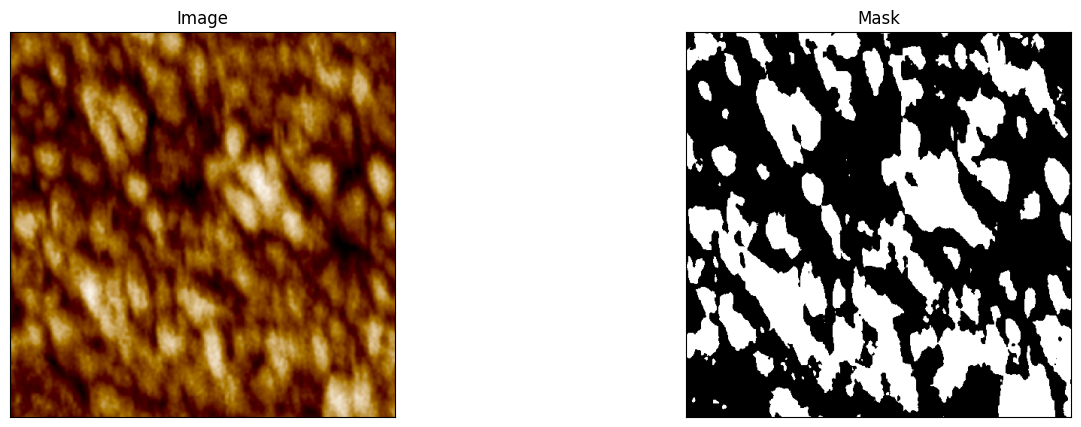

In [23]:
dataset = Dataset(x_train_dir, y_train_dir)

image, mask = dataset[73] # get some sample
visualize(
    image=image, 
    mask=mask.squeeze(),
)

In [24]:
encoders = {}
encoders.update(efficient_net_encoders)

In [25]:
DEVICE = 'cuda'
ENCODER = "efficientnet-b5"
ENCODER_WEIGHTS = 'imagenet'
model = Unet(
    encoder_name=ENCODER,
    encoder_depth=5, 
    encoder_weights=ENCODER_WEIGHTS,
    decoder_use_batchnorm=True, 
    decoder_channels=(512, 256, 128, 64, 32),
    decoder_attention_type='scse', 
    in_channels=3,
    classes=1,
    activation='sigmoid', 
    aux_params=None,
)
preprocessing_fn = get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b5-b6417697.pth
100%|██████████| 117M/117M [00:00<00:00, 276MB/s] 


In [26]:
print(model)

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePaddi

In [27]:
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

# def get_preprocessing():

#     _transform = [
#         albu.Lambda(image=to_tensor, mask=to_tensor),
#     ]
#     return albu.Compose(_transform)

In [28]:
# train_dataset = Dataset(
#     x_train_dir, 
#     y_train_dir, 
#     augmentation=None, 
#     preprocessing=get_preprocessing(),
# )

# valid_dataset = Dataset(
#     x_valid_dir, 
#     y_valid_dir, 
#     augmentation=None, 
#     preprocessing=get_preprocessing(),
# )

train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=None, 
    preprocessing=get_preprocessing(preprocessing_fn),
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=None, 
    preprocessing=get_preprocessing(preprocessing_fn),
)


train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=True, num_workers=2)

In [29]:
loss = DiceLoss()
metrics = [
    IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [30]:
train_epoch = TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [31]:
epochs = 50
max_score = 0
iou_train = np.zeros(epochs)
loss_train = np.zeros(epochs)
iou_valid = np.zeros(epochs)
loss_valid = np.zeros(epochs)

for i in range(0, epochs):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    iou_train[i] = train_logs['iou_score']
    loss_train[i] = train_logs['dice_loss']
    iou_valid[i] = valid_logs['iou_score']
    loss_valid[i] = valid_logs['dice_loss']
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 30:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 120/120 [00:06<00:00, 18.65it/s, dice_loss - 0.1798, iou_score - 0.7595]
Model saved!

Epoch: 1
valid: 100%|██████████| 120/120 [00:06<00:00, 19.53it/s, dice_loss - 0.1444, iou_score - 0.7922]
Model saved!

Epoch: 2
valid: 100%|██████████| 120/120 [00:06<00:00, 19.19it/s, dice_loss - 0.1187, iou_score - 0.8192]
Model saved!

Epoch: 3
valid: 100%|██████████| 120/120 [00:06<00:00, 19.81it/s, dice_loss - 0.1042, iou_score - 0.8337] 
Model saved!

Epoch: 4
valid: 100%|██████████| 120/120 [00:06<00:00, 19.99it/s, dice_loss - 0.09692, iou_score - 0.8463]
Model saved!

Epoch: 5
valid: 100%|██████████| 120/120 [00:06<00:00, 19.78it/s, dice_loss - 0.09591, iou_score - 0.8423]

Epoch: 6
valid: 100%|██████████| 120/120 [00:06<00:00, 19.18it/s, dice_loss - 0.0996, iou_score - 0.8395] 

Epoch: 7
valid: 100%|██████████| 120/120 [00:06<00:00, 19.20it/s, dice_loss - 0.09516, iou_score - 0.8438]

Epoch: 8
valid: 100%|██████████| 120/120 [00:06<00:00, 19.15it/s, dice_lo

In [32]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=None, 
    preprocessing=get_preprocessing(preprocessing_fn),
    #preprocessing=get_preprocessing()
)

test1_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=None,
)

best_model = torch.load('./best_model.pth')

In [33]:
def myIoU(pre,label):
    matrix=pre+label
    TPFPFN=np.count_nonzero(matrix)
    TP=np.sum(matrix==2)
    iou=TP/TPFPFN
    return iou

def myPrc(pre,label):
    matrix=pre+label
    TP=np.sum(matrix==2)
    TPFP=np.count_nonzero(pre)
    precision=TP/TPFP
    return precision

def myRcl(pre,label):
    matrix=pre+label
    TP=np.sum(matrix==2)
    TPFN=np.count_nonzero(label)
    recall=TP/TPFN
    return recall

In [34]:
length=len(test_dataset)
IOU=0
Precision=0
Recall=0
for n in range(length):
    image, gt_mask = test_dataset[n]
    true_image,mask1 = test1_dataset[n]
    gt_mask = gt_mask.squeeze()
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    IOU+=myIoU(pr_mask,gt_mask)
    Precision+=myPrc(pr_mask,gt_mask)
    Recall+=myRcl(pr_mask,gt_mask)
IOU=IOU/length
Precision=Precision/length
Recall=Recall/length
print('IoU =',IOU)
print('Precision =',Precision)
print('Recall =',Recall)

IoU = 0.8675842342715888
Precision = 0.9063990777335327
Recall = 0.9603956003943849


In [ ]:
n = 20
image, gt_mask = test_dataset[n]
true_image,mask1 = test1_dataset[n]

gt_mask = gt_mask.squeeze()

x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
pr_mask = best_model.predict(x_tensor)
pr_mask = (pr_mask.squeeze().cpu().numpy().round())

visualize(
    image=true_image, 
    ground_truth_mask=gt_mask, 
    predicted_mask=pr_mask
)

In [ ]:
from matplotlib import pyplot as plt
plt.figure()
N = epochs
plt.plot(np.arange(0, N), iou_train, label="train_iou")
plt.plot(np.arange(0, N), loss_train, label="train_loss")
plt.plot(np.arange(0, N), iou_valid, label="val_iou")
plt.plot(np.arange(0, N), loss_valid, label="val_loss")
plt.title("Training IoU and Loss on U-Net")
plt.xlabel("Epoch")
plt.ylabel("Loss/IoU")
plt.legend()
plt.savefig('/kaggle/working/UPP_NONE.png')
plt.show()

In [ ]:
import pandas as pd
data=[iou_train,loss_train,iou_valid,loss_valid]
df=pd.DataFrame(data)
df.to_excel('/kaggle/working/UPP_NONE.xlsx',index=False)

In [ ]:
length